## Prepare Data

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
call_data = "../data/raw/call-center-data-v2-daily.csv"
df = pd.read_csv(call_data, parse_dates=["Date"])

In [22]:
# Convert time columns to total seconds
time_cols = ["Answer Speed (AVG)", "Talk Duration (AVG)", "Waiting Time (AVG)"]
for col in time_cols:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

In [23]:
# Set the Date column as the index
df.set_index("Date", inplace=True)

In [24]:
# Sort the index
df.sort_index(inplace=True)
print(df.head())
print("\n")
print(df.info())

            Incoming Calls  Answered Calls  Abandoned Calls  \
Date                                                          
2022-01-01             157             145               12   
2022-01-02              37              37                0   
2022-01-03             317             304               13   
2022-01-04             253             244                9   
2022-01-05             214             205                9   

            Answer Speed (AVG)  Talk Duration (AVG)  Waiting Time (AVG)  
Date                                                                     
2022-01-01                15.0                149.0               192.0  
2022-01-02                 3.0                126.0                35.0  
2022-01-03                18.0                 95.0               157.0  
2022-01-04                13.0                110.0               122.0  
2022-01-05                10.0                130.0               202.0  


<class 'pandas.core.frame.DataFrame'>


## Modeling (Baseline Model: Seasonal Naive Forecast)
the forecast for any given day is the value from the same day in the previous week.

In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
# 1. Split data chronologically
train = df[df.index < "2025-03-01"]
test = df[df.index >= "2025-03-01"]

In [27]:
# 2. Create the baseline forecast
test_dates = test.index
# We need the last 7 days of the training set to start the forecast
history = train["Incoming Calls"]

In [28]:
# Create predictions with Seasonal Naive (Weekly) - handle missing dates
predictions = []
actual_test_dates = []

for date in test_dates:
    # Find the date from 7 days ago
    last_week_date = date - pd.Timedelta(days=7)

    # Check if the date exists in the training data
    if last_week_date in history.index:
        prediction = history.loc[last_week_date]
        predictions.append(prediction)
        actual_test_dates.append(date)

# Create a series with the predictions for evaluation
predictions_series = pd.Series(predictions, index=actual_test_dates)
actual_values = test.loc[actual_test_dates, "Incoming Calls"]

print(f"Number of predictions made: {len(predictions)}")
print("Predictions (first 10):")
print(predictions_series.head(10))

Number of predictions made: 7
Predictions (first 10):
2025-03-01     85
2025-03-02     44
2025-03-03    393
2025-03-04    283
2025-03-05    241
2025-03-06    281
2025-03-07    298
dtype: int64


In [29]:
# 3. Evaluate the baseline model
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predictions_series)
rmse = np.sqrt(mean_squared_error(actual_values, predictions_series))
mape = mean_absolute_percentage_error(actual_values, predictions_series)

print("Seasonal Naive (Weekly) Baseline Model - Evaluation Metrics")
print("=" * 55)
print(f"Mean Absolute Error (MAE):           {mae:.2f}")
print(f"Root Mean Squared Error (RMSE):      {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} ({mape*100:.2f}%)")
print("=" * 55)

Seasonal Naive (Weekly) Baseline Model - Evaluation Metrics
Mean Absolute Error (MAE):           90.00
Root Mean Squared Error (RMSE):      111.61
Mean Absolute Percentage Error (MAPE): 0.4303 (43.03%)


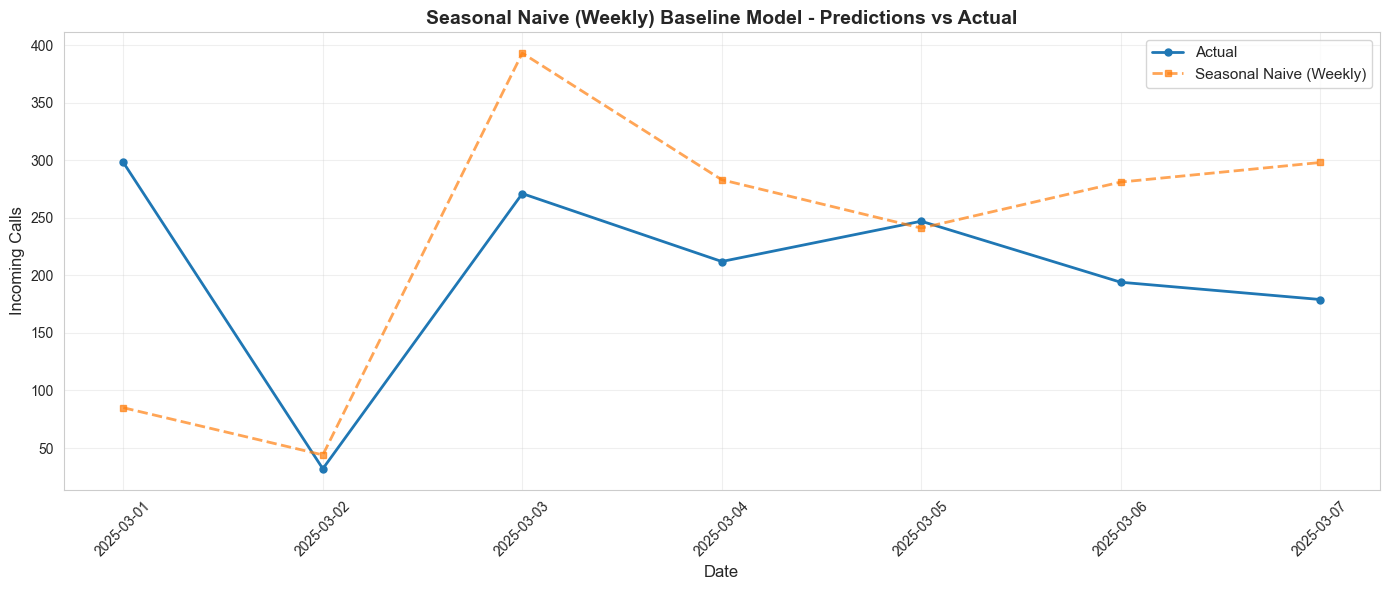


Prediction accuracy comparison:
Min calls: 32, Max calls: 298
Mean actual: 204.71, Mean predicted: 232.14


In [30]:
# 4. Visualize predictions vs actual values
plt.figure(figsize=(14, 6))

# Plot actual test values
plt.plot(actual_test_dates, actual_values, "o-", label="Actual", linewidth=2, markersize=5)

# Plot predictions
plt.plot(actual_test_dates, predictions_series, "s--", label="Seasonal Naive (Weekly)", linewidth=2, markersize=5, alpha=0.7)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Incoming Calls", fontsize=12)
plt.title("Seasonal Naive (Weekly) Baseline Model - Predictions vs Actual", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPrediction accuracy comparison:")
print(f"Min calls: {actual_values.min():.0f}, Max calls: {actual_values.max():.0f}")
print(f"Mean actual: {actual_values.mean():.2f}, Mean predicted: {predictions_series.mean():.2f}")

## Advanced Model: SARIMA (Seasonal AutoRegressive Integrated Moving Average)

In [31]:
# Install statsmodels if not already installed
import subprocess
import sys

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.tsa.statespace.sarimax import SARIMAX

Training SARIMA(1, 1, 1)x(1, 1, 1, 7) model...
Parameters: p=1, d=1, q=1 (non-seasonal), P=1, D=1, Q=1, m=7 (seasonal)

SARIMA Model trained successfully!

SARIMA Model - Evaluation Metrics
Mean Absolute Error (MAE):           95.50
Root Mean Squared Error (RMSE):      120.70
Mean Absolute Percentage Error (MAPE): 1.2462 (124.62%)


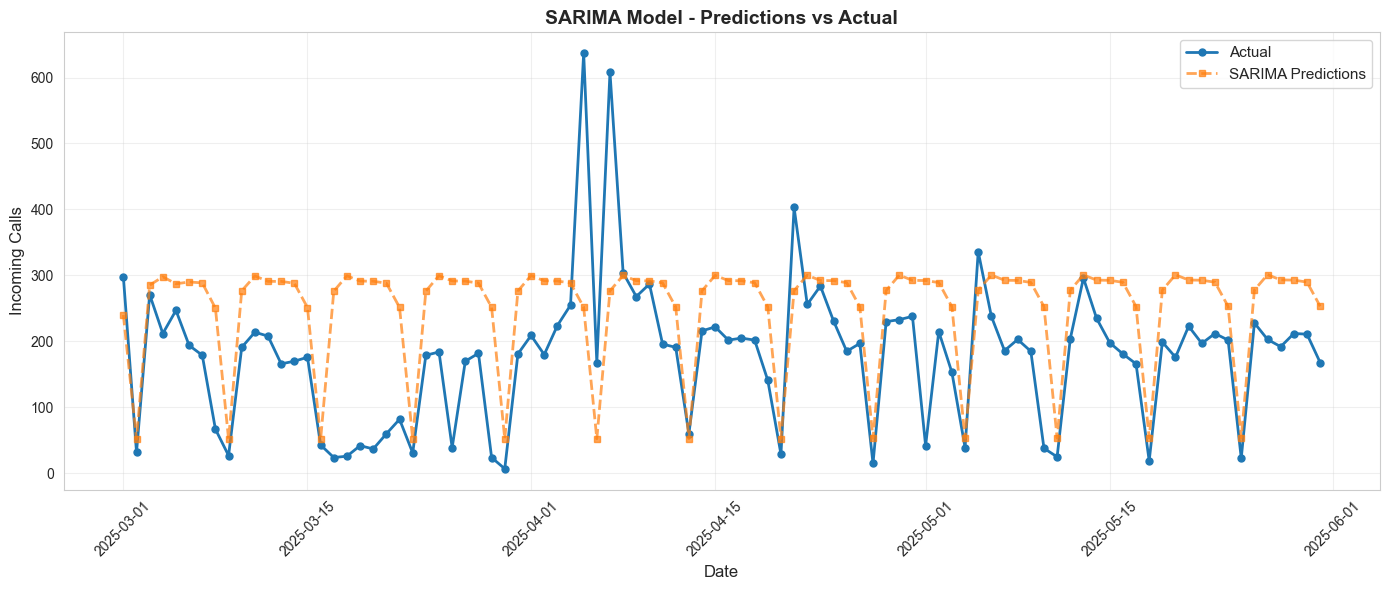

In [32]:
# Train SARIMA model with simple, proven parameters
# SARIMA(1,1,1)(1,1,1,7) - common good baseline for weekly seasonal data
import warnings

warnings.filterwarnings("ignore")

# Simple SARIMA parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, m) - m=7 for weekly seasonality

print(f"Training SARIMA{order}x{seasonal_order} model...")
print("Parameters: p=1, d=1, q=1 (non-seasonal), P=1, D=1, Q=1, m=7 (seasonal)\n")

sarima_model = SARIMAX(
    train["Incoming Calls"],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarima_results = sarima_model.fit(disp=False)
print("SARIMA Model trained successfully!")

# Make predictions on test set
sarima_predictions = sarima_results.get_forecast(steps=len(test))
sarima_forecast = sarima_predictions.predicted_mean

# Evaluate SARIMA model
sarima_mae = mean_absolute_error(test["Incoming Calls"], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test["Incoming Calls"], sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test["Incoming Calls"], sarima_forecast)

print("\n" + "=" * 60)
print("SARIMA Model - Evaluation Metrics")
print("=" * 60)
print(f"Mean Absolute Error (MAE):           {sarima_mae:.2f}")
print(f"Root Mean Squared Error (RMSE):      {sarima_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {sarima_mape:.4f} ({sarima_mape*100:.2f}%)")
print("=" * 60)

# Visualize predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(test.index, test["Incoming Calls"], "o-", label="Actual", linewidth=2, markersize=5)
plt.plot(test.index, sarima_forecast, "s--", label="SARIMA Predictions", linewidth=2, markersize=5, alpha=0.7)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Incoming Calls", fontsize=12)
plt.title("SARIMA Model - Predictions vs Actual", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Advanced Model: Prophet

In [33]:
# Install prophet if not already installed
import subprocess
import sys

try:
    from prophet import Prophet
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"])
    from prophet import Prophet

In [34]:
# Prepare data for Prophet
# Prophet requires columns 'ds' (datestamp) and 'y' (value)
prophet_train = train.reset_index()
prophet_train = prophet_train.rename(columns={"Date": "ds", "Incoming Calls": "y"})

# Initialize and train the model
prophet_model = Prophet(
    seasonality_mode="multiplicative",  # Good for data with trends
    weekly_seasonality=True,
    daily_seasonality=False,
)
prophet_model.fit(prophet_train)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Extract predictions for the test set period
prophet_forecast = forecast[forecast["ds"].isin(test.index)]

print("Prophet model trained and forecast generated.")
print(f"Forecast length: {len(prophet_forecast)}")

09:39:00 - cmdstanpy - INFO - Chain [1] start processing
09:39:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained and forecast generated.
Forecast length: 92


In [39]:
# Evaluate Prophet model
prophet_mae = mean_absolute_error(test["Incoming Calls"], prophet_forecast["yhat"])
prophet_rmse = np.sqrt(mean_squared_error(test["Incoming Calls"], prophet_forecast["yhat"]))
prophet_mape = mean_absolute_percentage_error(test["Incoming Calls"], prophet_forecast["yhat"])

print("\n" + "=" * 60)
print("Prophet Model - Evaluation Metrics")
print("=" * 60)
print(f"Mean Absolute Error (MAE):           {prophet_mae:.2f}")
print(f"Root Mean Squared Error (RMSE):      {prophet_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {prophet_mape:.4f} ({prophet_mape*100:.2f}%)")
print("=" * 60)


Prophet Model - Evaluation Metrics
Mean Absolute Error (MAE):           120.64
Root Mean Squared Error (RMSE):      158.27
Mean Absolute Percentage Error (MAPE): 1.4901 (149.01%)


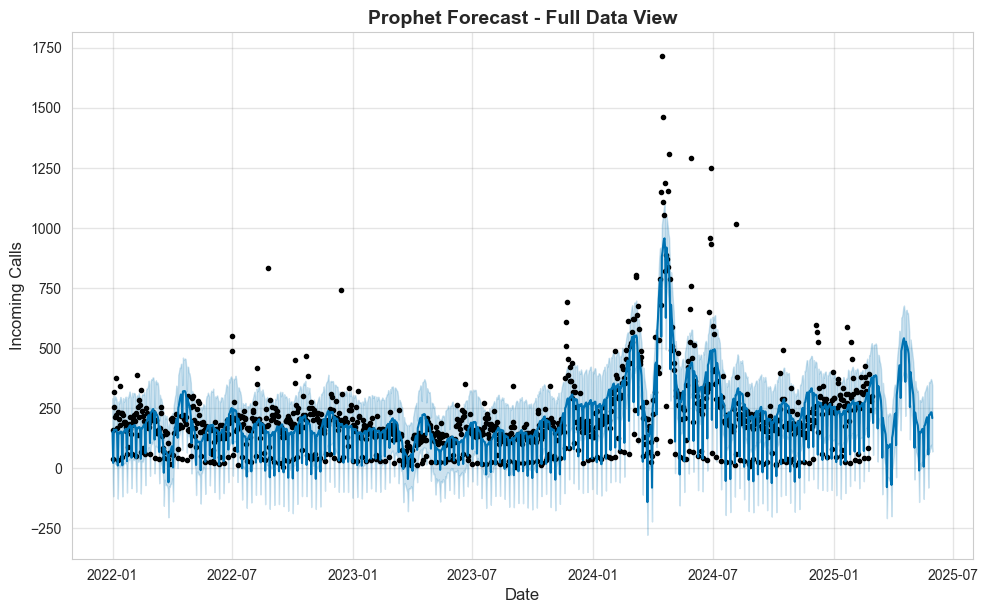

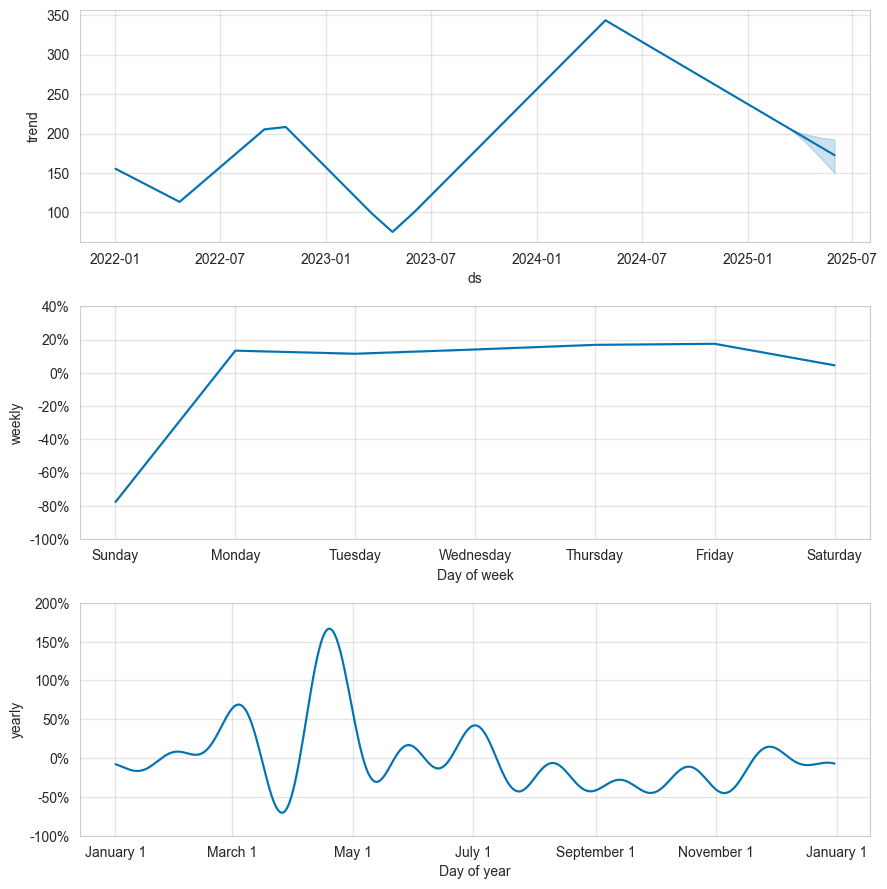

In [40]:
# Visualize Prophet forecast
fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast - Full Data View", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Incoming Calls", fontsize=12)
plt.show()

# Plot Prophet components
fig2 = prophet_model.plot_components(forecast)
plt.show()

In [41]:
# Compare all three models
comparison_df = pd.DataFrame(
    {
        "Seasonal Naive MAE": [mae],
        "Seasonal Naive RMSE": [rmse],
        "Seasonal Naive MAPE": [mape * 100],
        "SARIMA MAE": [sarima_mae],
        "SARIMA RMSE": [sarima_rmse],
        "SARIMA MAPE": [sarima_mape * 100],
        "Prophet MAE": [prophet_mae],
        "Prophet RMSE": [prophet_rmse],
        "Prophet MAPE": [prophet_mape * 100],
    }
)

print("\n" + "=" * 80)
print("MODEL COMPARISON - Baseline vs SARIMA vs Prophet")
print("=" * 80)
print(comparison_df.T)
print("=" * 80)


MODEL COMPARISON - Baseline vs SARIMA vs Prophet
                          0
Seasonal Naive MAE    90.00
Seasonal Naive RMSE  111.61
Seasonal Naive MAPE   43.03
SARIMA MAE            95.50
SARIMA RMSE          120.70
SARIMA MAPE          124.62
Prophet MAE          120.64
Prophet RMSE         158.27
Prophet MAPE         149.01


## Time Series Cross-Validation for SARIMA

In [42]:
# Time Series Cross-Validation for SARIMA
# This uses a rolling window approach: train on increasing data, test on next period


def time_series_cv_sarima(data, n_splits=5, test_size=7):
    """
    Perform time series cross-validation for SARIMA model

    Args:
        data: Time series data (pandas Series)
        n_splits: Number of cross-validation splits
        test_size: Number of periods to use for testing in each split

    Returns:
        List of MAE scores for each fold
    """

    # Calculate split points
    total_length = len(data)
    min_train_size = total_length - n_splits * test_size

    mae_scores = []
    rmse_scores = []
    mape_scores = []

    print(f"Performing {n_splits}-fold time series cross-validation...")
    print(f"Test size per fold: {test_size} days")
    print(f"Minimum training size: {min_train_size} days\n")

    for i in range(n_splits):
        # Calculate train and test indices
        test_end = total_length - i * test_size
        test_start = test_end - test_size
        train_end = test_start

        # Split data
        cv_train = data.iloc[:train_end]
        cv_test = data.iloc[test_start:test_end]

        print(f"Fold {i+1}/{n_splits}: Train size = {len(cv_train)}, Test size = {len(cv_test)}")

        try:
            # Train SARIMA model
            cv_model = SARIMAX(
                cv_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            cv_results = cv_model.fit(disp=False)

            # Make predictions
            cv_forecast = cv_results.get_forecast(steps=len(cv_test))
            cv_pred = cv_forecast.predicted_mean

            # Calculate metrics
            mae = mean_absolute_error(cv_test, cv_pred)
            rmse = np.sqrt(mean_squared_error(cv_test, cv_pred))
            mape = mean_absolute_percentage_error(cv_test, cv_pred)

            mae_scores.append(mae)
            rmse_scores.append(rmse)
            mape_scores.append(mape)

            print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")

        except Exception as e:
            print(f"  Error in fold {i+1}: {e}")
            continue

    return mae_scores, rmse_scores, mape_scores


# Perform cross-validation on the training data
cv_mae, cv_rmse, cv_mape = time_series_cv_sarima(train["Incoming Calls"], n_splits=5, test_size=7)

Performing 5-fold time series cross-validation...
Test size per fold: 7 days
Minimum training size: 1120 days

Fold 1/5: Train size = 1148, Test size = 7
  MAE: 97.37, RMSE: 114.70, MAPE: 0.8033
Fold 2/5: Train size = 1141, Test size = 7
  MAE: 40.78, RMSE: 51.97, MAPE: 0.2637
Fold 3/5: Train size = 1134, Test size = 7
  MAE: 113.42, RMSE: 119.14, MAPE: 0.6790
Fold 4/5: Train size = 1127, Test size = 7
  MAE: 64.14, RMSE: 102.29, MAPE: 0.8431
Fold 5/5: Train size = 1120, Test size = 7
  MAE: 80.09, RMSE: 107.59, MAPE: 0.4220


In [43]:
# Analyze cross-validation results
if cv_mae:  # Check if we have results
    print("\n" + "=" * 60)
    print("TIME SERIES CROSS-VALIDATION RESULTS")
    print("=" * 60)

    print(f"Number of successful folds: {len(cv_mae)}")
    print("\nMAE Scores by Fold:")
    for i, mae in enumerate(cv_mae, 1):
        print(f"  Fold {i}: {mae:.2f}")

    print("\nCross-Validation Summary:")
    print(f"  Mean MAE:  {np.mean(cv_mae):.2f} ± {np.std(cv_mae):.2f}")
    print(f"  Mean RMSE: {np.mean(cv_rmse):.2f} ± {np.std(cv_rmse):.2f}")
    print(f"  Mean MAPE: {np.mean(cv_mape):.4f} ± {np.std(cv_mape):.4f}")

    print("\nComparison with Single Test:")
    print(f"  Single Test MAE:  {sarima_mae:.2f}")
    print(f"  CV Mean MAE:      {np.mean(cv_mae):.2f}")
    print(f"  Difference:       {abs(sarima_mae - np.mean(cv_mae)):.2f}")

    print("=" * 60)
else:
    print("No successful cross-validation folds completed.")


TIME SERIES CROSS-VALIDATION RESULTS
Number of successful folds: 5

MAE Scores by Fold:
  Fold 1: 97.37
  Fold 2: 40.78
  Fold 3: 113.42
  Fold 4: 64.14
  Fold 5: 80.09

Cross-Validation Summary:
  Mean MAE:  79.16 ± 25.32
  Mean RMSE: 99.14 ± 24.29
  Mean MAPE: 0.6022 ± 0.2242

Comparison with Single Test:
  Single Test MAE:  95.50
  CV Mean MAE:      79.16
  Difference:       16.33
